![Partners](../images/partners.png)

# Solar Power Generation

This notebook demonstrates how to forecast solar power output using weather data from AIFS (AI Integrated Forecasting System) and compare it against climatological averages.

## 1. Imports

In [2]:
from pathlib import Path
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd

import warnings
warnings.filterwarnings("ignore")

## 2. Get Solar Power Plants Data

In [3]:
# Select country to visualize
selected_country = "Kenya"  # Change this to any country 

gdf = gpd.read_file("data/RePP/RePP_short_FeaturesToJSON.geojson")

# Filter data for selected country
country_data = gdf[gdf.country == selected_country]

# list of all operating solar power plants in the selected country   
solar_plants = country_data[(country_data['RE_source'] == 'Solar power') & (country_data['stat_ele'] == 'O')].sort_values(by='g_cap_mw', ascending=False)

In [4]:
# example choose first plant
plant = solar_plants.iloc[0]
location_name = plant['HPP_name']
lat_point = plant['lat']
lon_point = plant['lon']
g_cap_mw = plant['g_cap_mw']

# print
print(f"Selected Plant: {location_name}, Capacity: {g_cap_mw} MW, Location: ({lat_point}, {lon_point})")

Selected Plant: Garissa, Capacity: 54.7 MW, Location: (-0.31567527799995787, 39.69933718900006)


## 2. Get AIFS Forecast Data

Forecast for 2025-11-06 run 00:00:00 is already downloaded in `data/AIFS/output/`. This is available for backup option in case of download issues.

In [ ]:

# backup option, change if newer data is downloaded
forecast_fn = Path("data/AIFS/output/20251106000000-360h_ssrd.nc")
ds = xr.open_dataset(forecast_fn)

In [6]:
forecast_location = ds['ssrd'].sel(
    latitude=lat_point, 
    longitude=lon_point, 
    method='nearest'
)

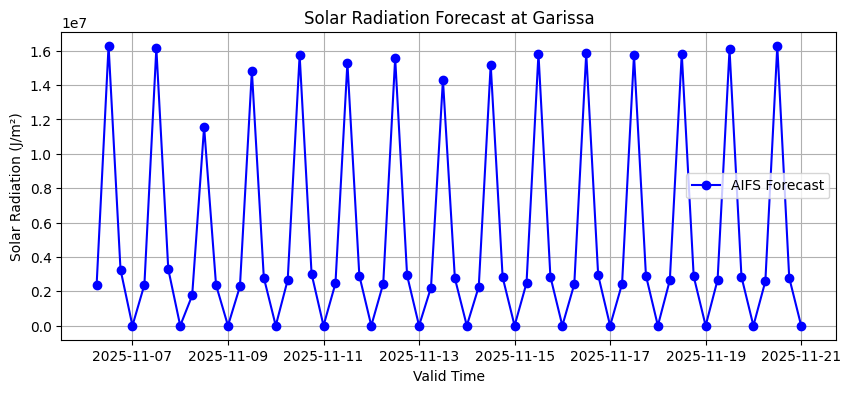

In [7]:
# take the difference to get flux from cumulative
diff = forecast_location.diff("step")

# skip first value which is nan after diff
valid_times = forecast_location.valid_time[1:]

plt.figure(figsize=(10, 4))
plt.plot(valid_times, diff, marker='o', label='AIFS Forecast', color='blue')
plt.title(f'Solar Radiation Forecast at {location_name}')
plt.xlabel('Valid Time')
plt.ylabel('Solar Radiation (J/m²)')
plt.grid()
plt.legend()

In [8]:
 # now get the daily sum from 6h intervals
forecast_sum_daily = diff.groupby("valid_time.day").sum(dim="step")

# skip last day if incomplete
forecast_sum_daily = forecast_sum_daily[:-2]

valid_times_days = pd.date_range(
    start=pd.to_datetime(valid_times.values[0]).replace(hour=0, minute=0, second=0),
    end=pd.to_datetime(valid_times.values[-1]).replace(hour=0, minute=0, second=0),
    freq='D'
)[:-2]

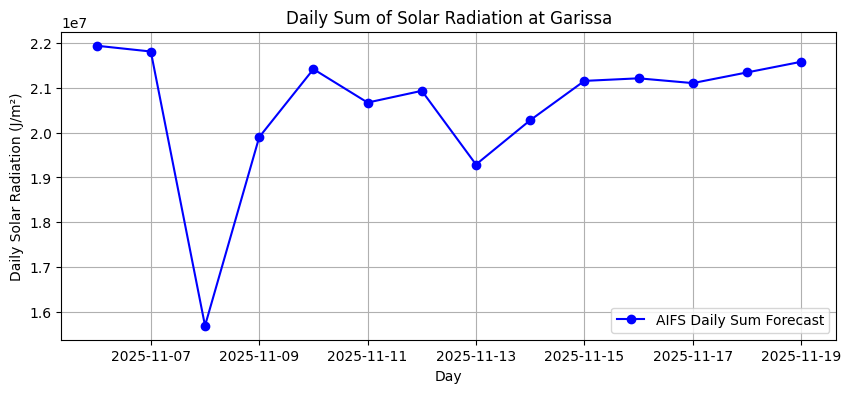

In [9]:
# plot 
plt.figure(figsize=(10, 4))
plt.plot(valid_times_days, forecast_sum_daily, marker='o', label='AIFS Daily Sum Forecast', color='blue')
plt.title(f'Daily Sum of Solar Radiation at {location_name}')
plt.xlabel('Day')
plt.ylabel('Daily Solar Radiation (J/m²)')
plt.grid()
plt.legend()
plt.show()

In [10]:
# open climatology data
climatology_file = Path("data/climatology/surface_solar_radiation_downwards_climatology.nc")
ds_clim = xr.open_dataset(climatology_file)

# Extract forecast at location
clim_location = ds_clim['ssrd'].sel(
    latitude=lat_point, 
    longitude=lon_point, 
    method='nearest'
)

# Extract climatology for forecast period
clim_forecast_period = clim_location.sel(dayofyear=list(valid_times_days.dayofyear))

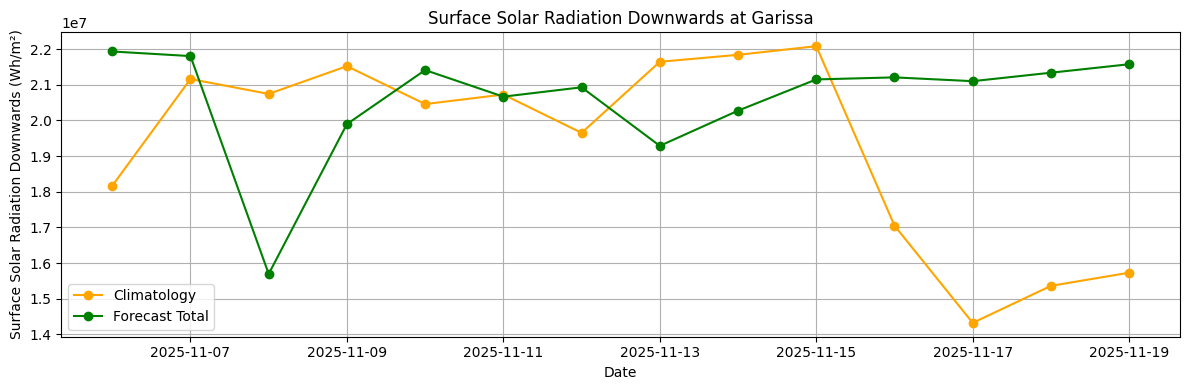

In [11]:
plt.figure(figsize=(12, 4))
plt.plot(valid_times_days, clim_forecast_period*4, marker='o', label='Climatology', color='orange')
plt.plot(valid_times_days, forecast_sum_daily, marker='o', label='Forecast Total', color='green')
plt.title(f'Surface Solar Radiation Downwards at {location_name}')
plt.xlabel('Date')
plt.ylabel('Surface Solar Radiation Downwards (Wh/m²)')
plt.legend()
plt.grid()
plt.tight_layout()

## 4. Solar Power Forecast

Calculate power output based on the ratio of forecasted to climatological solar radiation.

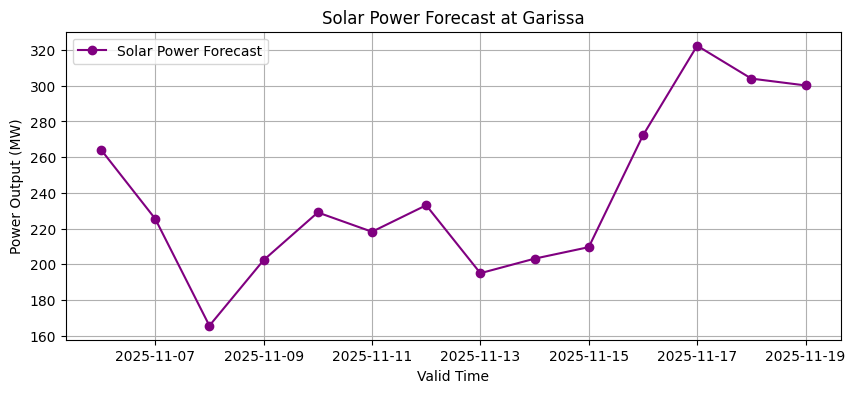

In [12]:
def solar_power(
    GHI: np.ndarray,
    GHI_clim: np.ndarray,
    C_pv: float = 0.2
) -> np.ndarray:
    """
    Simple solar power model.
    Parameters:
    GHI : xarray.DataArray
        the forecasted global horizontal irradiance [W/m²]
    GHI_clim : xarray.DataArray
        the long-term average (climatological) irradiance [W/m²]
    C_pv : float
        the total installed photovoltaic (PV) capacity [MW]
    """
    
    P_pv = C_pv * (GHI / GHI_clim)

    return P_pv


power_forecast = solar_power(
    GHI=forecast_sum_daily.values,  # convert J/m² to W/m
    GHI_clim=(clim_forecast_period).values,  # convert J/m² to W/m²
    C_pv=g_cap_mw
)


plt.figure(figsize=(10, 4))
plt.plot(valid_times_days, power_forecast, marker='o', label='Solar Power Forecast',
            color='purple')
plt.title(f'Solar Power Forecast at {location_name}')
plt.xlabel('Valid Time')
plt.ylabel('Power Output (MW)')
plt.grid()
plt.legend()
plt.show()